In [40]:
import re, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import string, nltk, warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [41]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [42]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [43]:
combi= train.append(test, ignore_index=True, sort=True)

In [44]:
def remove_pattern(input_txt, pattern):
    r= re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [45]:
#remove twitter handles (@user)
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")

In [46]:
#remove punctuations, special char
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [47]:
#remove short words
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [48]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [49]:
#Tokenization 
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [50]:
#Stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [51]:
#untokenize
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
combi['tidy_tweet'] = tokenized_tweet

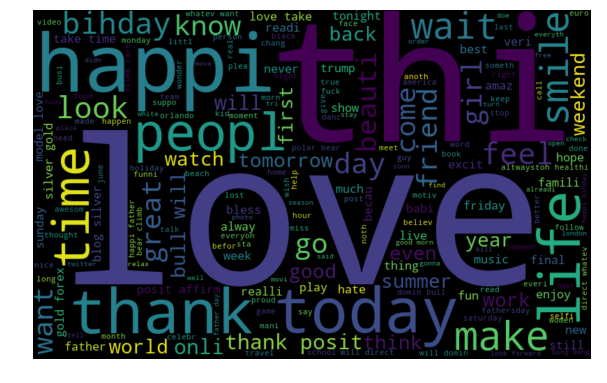

In [52]:
#Word Cloud
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

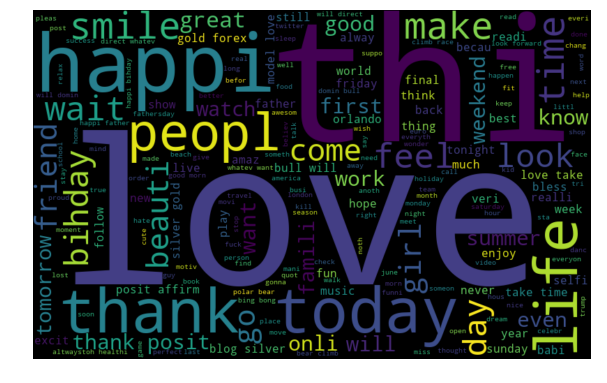

In [53]:
#Word Cloud
normal_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

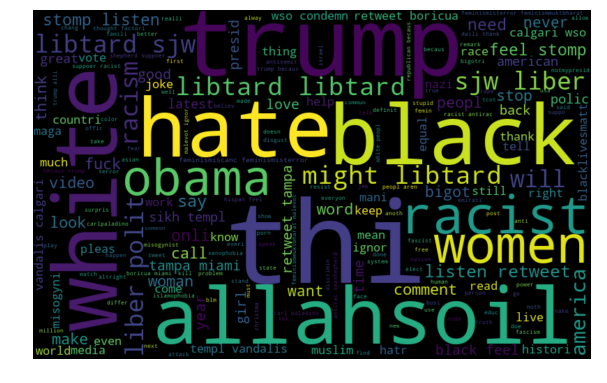

In [54]:
#Racist/sexist tweets
neg_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21).generate(neg_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [55]:
#Function to collect Hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
        
    return hashtags
#Extracting from non racist/sexist tweets
HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])
                                                 
#Extracting from racist/sexist tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])
                                                 
#Unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])
                                                 
                                                 

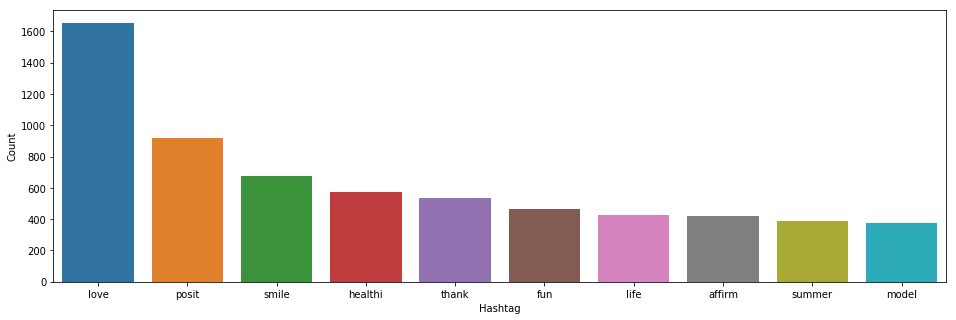

In [56]:
#Non racist/sexist tweets
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),'Count': list(a.values()) })

#Selecting top 10 most frequent hashtags
d = d.nlargest(columns="Count", n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x="Hashtag", y="Count")
ax.set(ylabel = 'Count')
plt.show()

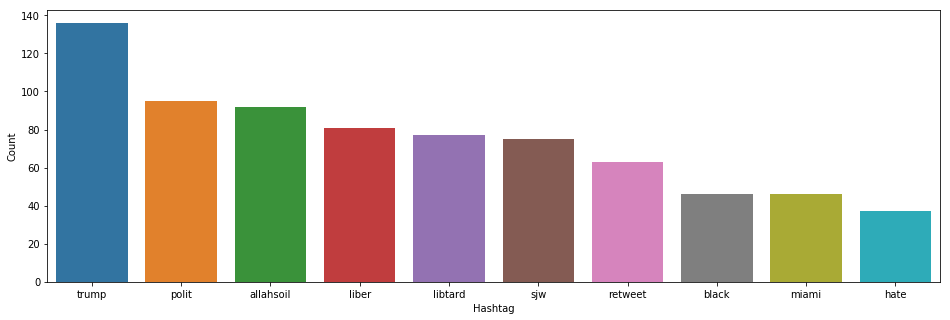

In [57]:
#Racist/sexist tweets
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()),'Count': list(b.values()) })

#Selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x="Hashtag", y="Count")
ax.set(ylabel = 'Count')
plt.show()

In [58]:
#Extracting Features from cleaned tweets

#Bag of words Features
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=.90, min_df=2, max_features=1000, stop_words='english')

#bag of words feature matrix
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])

In [59]:
#TF-IDF Features
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=.90, min_df=2, max_features=1000, stop_words='english')

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])

In [60]:
#Model Building using bag of words
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:31962, :]
test_bow = bow[31962:, :]

#Splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)
    
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain)

prediction = lreg.predict_proba(xvalid_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

C:\Users\Blasphemy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5307820299500832

In [61]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id', 'label']]
submission.to_csv('sub_lreg_bow.csv', index=False)

In [62]:
#Model Building using TF-IDF Features
train_tfidf = tfidf[:31962, :]
test_tfidf = tfidf[31962:, :]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

0.5446507515473032